# CNN Training Script

This notebook defines and trains two CNN models:
- Model 1: Predicts turbidity based on dam presence and seasonal input.
- Model 2: Predicts diatom concentration based on turbidity using ConvLSTM.

In [21]:
import os
import numpy as np
import rasterio
from datetime import datetime
from PIL import Image
import netCDF4  # for reading .nc (NetCDF) files
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Custom loss function: Mean Squared Error that ignores missing values (NaN or 0 in y_true).
def masked_mse(y_true, y_pred):
    # Create mask of valid (non-missing) targets: 1 where y_true is not NaN and not 0
    mask = tf.math.logical_and(~tf.math.is_nan(y_true), tf.math.not_equal(y_true, 0.0))
    mask = tf.cast(mask, tf.float32)
    # Replace NaNs in y_true with 0 so they don't produce NaN errors in subtraction
    y_true_clean = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)
    # Compute squared errors
    squared_error = tf.square(y_pred - y_true_clean)
    # Apply mask: only keep errors for valid points
    masked_squared_error = squared_error * mask
    # Compute mean error over all valid points
    mse_value = tf.reduce_sum(masked_squared_error) / tf.reduce_sum(mask)
    return mse_value


## Model 1: Dam to Turbidity Prediction


In [22]:
# Directory containing turbidity .tif files (update this path as yours will be different).
turbidity_dir = "/home/user/MSc/Clean_Codebase/data/processed/turbidity"

# Define the dam construction date (for flagging the input). Example:
dam_construction_date = datetime(2023, 1, 15)

# Whether to include seasonal date encoding in input features
include_date = True

# List and sort all turbidity files
all_files = os.listdir(turbidity_dir)
tif_files = [f for f in all_files if f.endswith('.tif')]
tif_files.sort()  # sort by filename (which should correspond to date order)
file_paths = [os.path.join(turbidity_dir, f) for f in tif_files]

input_features = []
output_maps = []

for file_path in file_paths:
    fname = os.path.basename(file_path)
    # Extract date from filename by grabbing the first 8 digits (YYYYMMDD)
    digits = ''.join([ch for ch in fname if ch.isdigit()])
    if len(digits) >= 8:
        try:
            date = datetime.strptime(digits[:8], "%Y%m%d")
        except ValueError:
            date = None
    else:
        date = None

    # Determine dam flag (1 if date is on/after dam construction, else 0)
    if date is not None and date >= dam_construction_date:
        dam_flag = 1.0
    else:
        dam_flag = 0.0

    # Build input feature vector
    if include_date and date is not None:
        # Calculate day-of-year for seasonal encoding
        day_of_year = date.timetuple().tm_yday
        sin_day = np.sin(2 * np.pi * day_of_year / 365.0)
        cos_day = np.cos(2 * np.pi * day_of_year / 365.0)
        features = np.array([dam_flag, sin_day, cos_day], dtype=np.float32)
    else:
        # Only dam flag as feature (if date is missing or date encoding not included)
        features = np.array([dam_flag], dtype=np.float32)

    # Load the turbidity data from the TIFF file
    with rasterio.open(file_path) as src:
        turb_data = src.read(1)  # read the first band into a 2D array

    turb_array = turb_data.astype(np.float32)
    # Replace fill/missing values (e.g., -9999) with NaN
    turb_array[turb_array == -9999] = np.nan

    # Normalize turbidity values to [0, 1] range using the max value (ignore NaNs)
    if not np.all(np.isnan(turb_array)):  # proceed if there is at least one valid value
        max_val = np.nanmax(turb_array)
        if max_val > 0:
            turb_array = turb_array / max_val
    # Replace any NaNs (missing data) with 0 after normalization
    turb_array = np.nan_to_num(turb_array, nan=0.0)

    # Resize the turbidity array to 60x60 using bilinear interpolation
    img = Image.fromarray(turb_array)  # create a PIL image from the array
    img_resized = img.resize((60, 60), resample=Image.BILINEAR)
    resized_array = np.array(img_resized, dtype=np.float32)

    # Add a channel dimension to the turbidity map (so it becomes HxW x1)
    resized_array = np.expand_dims(resized_array, axis=-1)

    # Store the features and output
    input_features.append(features)
    output_maps.append(resized_array)

# Convert lists to numpy arrays for training
X_data = np.stack(input_features)  # shape: (num_samples, input_dim)
Y_data = np.stack(output_maps)     # shape: (num_samples, 60, 60, 1)

print(f"Prepared {X_data.shape[0]} samples for Model 1.")
print(f"Input feature shape: {X_data.shape}, Output map shape: {Y_data.shape}")


Prepared 27 samples for Model 1.
Input feature shape: (27, 3), Output map shape: (27, 60, 60, 1)


## Building and Compiling Model 1


In [23]:
# Determine input dimensionality from the prepared data
input_dim = X_data.shape[1]

# Build Model 1 using a Sequential API for simplicity
model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(input_dim,)))
model1.add(layers.Dense(15 * 15 * 16, activation='relu'))  # project to 15x15x16 features
model1.add(layers.Reshape((15, 15, 16)))                   # reshape to 15x15 image with 16 channels
model1.add(layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu'))  # upsample to ~30x30
model1.add(layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', activation='relu'))   # upsample to ~60x60
model1.add(layers.Conv2D(1, (3, 3), padding='same', activation='linear', name="TurbidityOutput"))  # final output 60x60x1

# Compile the model with Adam optimizer and masked MSE loss
model1.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=masked_mse)

# Print model summary to verify architecture
model1.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3600)           │       234,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 30, 30, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 60, 60, 8)      │         1,160 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TurbidityOutput (Conv2D)        │ (None, 60, 60, 1)      │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,809 (928.94 KB)

 Trainable params: 237,809 (928.94 KB)

 Non-trainable params: 0 (0.00 B)

# Training Model 1

In [24]:
# Training parameters
epochs = 50
batch_size = 8

print(" Starting training for Model 1 (Dam to Turbidity)...")
history1 = model1.fit(X_data, Y_data, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

# Create directory to save the model if it doesn't exist
model_dir = "/home/user/MSc/Clean_Codebase/models"
os.makedirs(model_dir, exist_ok=True)
# Save the trained Model 1
model1.save(os.path.join(model_dir, "model1_dam_to_turbidity.h5"))
print(f" Model 1 training complete. Model saved to: {model_dir}/model1_dam_to_turbidity.h5")


 Starting training for Model 1 (Dam to Turbidity)...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.3814e-05
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.9327e-05
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.5613e-05
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.7655e-06
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1662e-05
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8630e-05
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3288e-05
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3100e-05
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.5121e-06
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.1104e-06
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3631e-05
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2208e-05
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.5205e-06
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1

 Model 1 training complete. Model saved to: /home/user/MSc/Clean_Codebase/models/model1_dam_to_turbidity.h5


## Model 2: Turbidity to Diatom Prediction

In [25]:
# Directories for turbidity and diatom data (update these paths as needed)
turbidity_dir = "/home/user/MSc/Clean_Codebase/data/processed/turbidity"      # (reuse the turbidity_dir from Model 1 if same data)
diatom_dir = "/home/user/MSc/Clean_Codebase/data/processed/phytoplankton"

# Sequence length: how many past turbidity maps to use for each diatom prediction
seq_length = 3

# List and sort turbidity and diatom files
turb_files = [f for f in os.listdir(turbidity_dir) if f.endswith('.tif')]
turb_files.sort()
turb_paths = [os.path.join(turbidity_dir, f) for f in turb_files]

diatom_files = [f for f in os.listdir(diatom_dir) if f.endswith('.nc')]
diatom_files.sort()
diatom_paths = [os.path.join(diatom_dir, f) for f in diatom_files]

# Parse dates from filenames
turb_dates = []
for f in turb_files:
    digits = ''.join([ch for ch in f if ch.isdigit()])
    if len(digits) >= 8:
        try:
            date = datetime.strptime(digits[:8], "%Y%m%d")
        except ValueError:
            date = None
    else:
        date = None
    turb_dates.append(date)

diatom_dates = []
for f in diatom_files:
    digits = ''.join([ch for ch in f if ch.isdigit()])
    if len(digits) >= 8:
        try:
            date = datetime.strptime(digits[:8], "%Y%m%d")
        except ValueError:
            date = None
    else:
        date = None
    diatom_dates.append(date)

# Match diatom dates with sequences of turbidity data
samples = []  # will hold tuples of (turbidity_indices_list, diatom_index)
for diatom_idx, diat_date in enumerate(diatom_dates):
    if diat_date is None:
        continue  # skip if diatom date couldn't be determined
    if diat_date in turb_dates:
        turb_idx = turb_dates.index(diat_date)
        # Determine the indices for the previous seq_length turbidity maps
        start_idx = turb_idx - seq_length
        if start_idx >= 0:
            seq_indices = list(range(start_idx, turb_idx))  # indices of turbidity frames before diat_date
            # Ensure all required turbidity dates exist (not None)
            if all(turb_dates[i] is not None for i in seq_indices):
                samples.append((seq_indices, diatom_idx))

print(f"Found {len(samples)} matching samples with sequence length {seq_length} for Model 2.")

# Prepare lists for input sequences and output maps
turb_seq_list = []
diat_map_list = []

for seq_indices, diatom_idx in samples:
    # Load turbidity sequence
    seq_frames = []
    for turb_index in seq_indices:
        turb_path = turb_paths[turb_index]
        with rasterio.open(turb_path) as src:
            turb_data = src.read(1)
        turb_array = turb_data.astype(np.float32)
        turb_array[turb_array == -9999] = np.nan  # handle fill values
        # Normalize each turbidity frame
        if not np.all(np.isnan(turb_array)):
            max_val = np.nanmax(turb_array)
            if max_val > 0:
                turb_array = turb_array / max_val
        turb_array = np.nan_to_num(turb_array, nan=0.0)
        # Resize to 60x60
        img = Image.fromarray(turb_array)
        img_resized = img.resize((60, 60), resample=Image.BILINEAR)
        resized_turb = np.array(img_resized, dtype=np.float32)
        # Add channel dimension
        resized_turb = np.expand_dims(resized_turb, axis=-1)
        seq_frames.append(resized_turb)
    # Stack sequence frames into array of shape (seq_length, 60, 60, 1)
    turb_sequence = np.stack(seq_frames)

    # Load diatom data
    diat_path = diatom_paths[diatom_idx]
    ds = netCDF4.Dataset(diat_path)
    # Try to get the diatom variable (assuming it's named 'Diat')
    if 'Diat' in ds.variables:
        diat_var = ds.variables['Diat']
        # If the variable has a time dimension (e.g., shape [time, lat, lon]), take the first time step
        if diat_var.ndim == 3:
            diat_data = diat_var[0, :, :]
        else:
            diat_data = diat_var[:, :]
    else:
        # Fallback: if 'Diat' not found, use the first 2D variable in the dataset
        diat_data = None
        for var_name, var in ds.variables.items():
            if var.ndim == 2:
                diat_data = var[:, :]
                break
        if diat_data is None:
            ds.close()
            continue  # skip if no 2D data found
    ds.close()

    diat_array = np.array(diat_data, dtype=np.float32)
    diat_array[diat_array == -9999] = np.nan  # replace fill values with NaN
    # Normalize diatom values to [0, 1]
    if not np.all(np.isnan(diat_array)):
        max_val = np.nanmax(diat_array)
        if max_val > 0:
            diat_array = diat_array / max_val
    diat_array = np.nan_to_num(diat_array, nan=0.0)
    # Resize diatom map to 60x60
    img = Image.fromarray(diat_array)
    img_resized = img.resize((60, 60), resample=Image.BILINEAR)
    resized_diat = np.array(img_resized, dtype=np.float32)
    # Add channel dimension
    resized_diat = np.expand_dims(resized_diat, axis=-1)

    # Store sequence and corresponding diatom map
    turb_seq_list.append(turb_sequence)
    diat_map_list.append(resized_diat)

# Convert lists to numpy arrays
X2_data = np.array(turb_seq_list)  # shape: (num_samples, seq_length, 60, 60, 1)
Y2_data = np.array(diat_map_list)  # shape: (num_samples, 60, 60, 1)

print(f"Prepared {X2_data.shape[0]} samples for Model 2.")
print(f"Input sequence shape: {X2_data.shape}, Output map shape: {Y2_data.shape}")


Found 24 matching samples with sequence length 3 for Model 2.
Prepared 24 samples for Model 2.
Input sequence shape: (24, 3, 60, 60, 1), Output map shape: (24, 60, 60, 1)


## Building and Compiling Model 2

In [26]:
# Build Model 2
model2 = models.Sequential()
model2.add(layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',
                              return_sequences=True, activation='relu', input_shape=(seq_length, 60, 60, 1)))
model2.add(layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same',
                              return_sequences=False, activation='relu'))
model2.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu'))   # refine spatial features
model2.add(layers.Conv2D(1, (1, 1), padding='same', activation='linear', name="DiatomOutput"))  # output diatom map

# Compile Model 2
model2.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=masked_mse)

# Print summary to verify architecture
model2.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 3, 60, 60, 32)  │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 60, 60, 16)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DiatomOutput (Conv2D)           │ (None, 60, 60, 1)      │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,025 (261.82 KB)

 Trainable params: 67,025 (261.82 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model 2

In [27]:
# Training parameters for Model 2
epochs = 50
batch_size = 4

print("\n Starting training for Model 2 (Turbidity ➜ Diatoms)...")
history2 = model2.fit(X2_data, Y2_data, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

# Save the trained Model 2
model2.save(os.path.join(model_dir, "model2_turbidity_to_diatom.h5"))
print(f" Model 2 training complete. Model saved to: {model_dir}/model2_turbidity_to_diatom.h5")



 Starting training for Model 2 (Turbidity ➜ Diatoms)...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0013
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0014
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0013
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0013
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0013
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0013
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0013
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0013
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 0.0013
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0013
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0013
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0013
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0013
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.0013
Epoch 15/50
6/6 ━━━━━━━━━━━━

 Model 2 training complete. Model saved to: /home/user/MSc/Clean_Codebase/models/model2_turbidity_to_diatom.h5


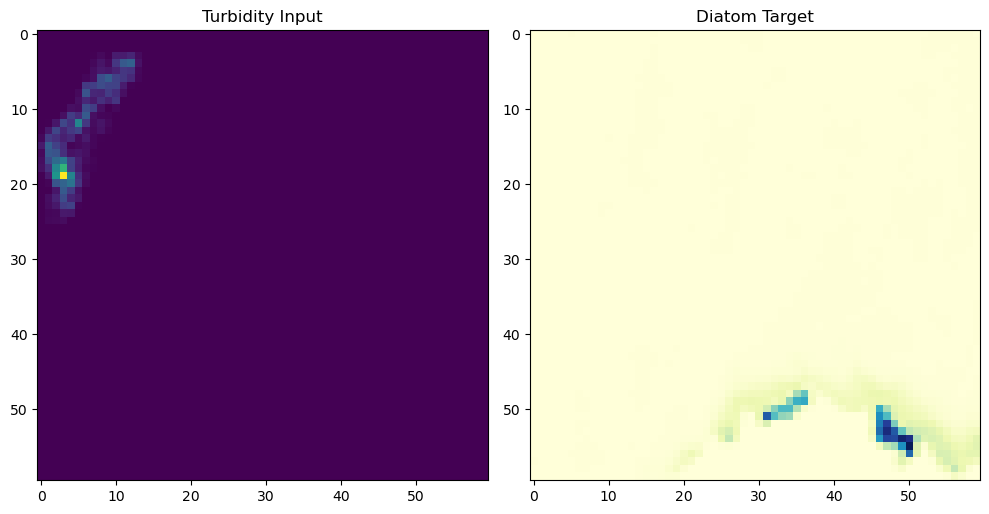

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X2_data[0][-1, :, :, 0], cmap="viridis")
plt.title("Turbidity Input")

plt.subplot(1, 2, 2)
plt.imshow(Y2_data[0][:, :, 0], cmap="YlGnBu")
plt.title("Diatom Target")

plt.tight_layout()
plt.show()
